In [6]:
import math

tx_power_mw = 7.5
rx_sensitivity_dbm = -80
frequency_hz = 5.9e9

tx_power_dbm = 10 * math.log10(tx_power_mw)

max_path_loss_db = tx_power_dbm - rx_sensitivity_dbm

log10_d = (max_path_loss_db + 147.55 - 20 * math.log10(frequency_hz)) / 20
distance_m = 10 ** log10_d

print(f"송신 전력: {tx_power_dbm:.2f} dBm")
print(f"최대 경로 손실: {max_path_loss_db:.2f} dB")
print(f"전송 가능 최대 거리: {distance_m:.2f} m")


송신 전력: 8.75 dBm
최대 경로 손실: 88.75 dB
전송 가능 최대 거리: 110.71 m


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 분석할 노드 목록
nodes = ["node[0]", "node[4]", "node[6]", "node[9]", "node[10]", "node[11]", "node[17]", "node[22]", "node[29]"]

# 명확한 파일 경로 지정
exp_files = {
    "제안 기법": "/mnt/data/lifetime_expired_log-P.csv",
    "기존 방식": "/mnt/data/lifetime_expired_log-L.csv"
}
log_files = {
    "제안 기법": "/mnt/data/aodv_routing_log-P.csv",
    "기존 방식": "/mnt/data/aodv_routing_log-L.csv"
}

# 복구 지연 계산 함수
def compute_recovery_delays(expired_path, routing_path):
    df_exp = pd.read_csv(expired_path, names=["Node", "Destination", "Time"])
    df_log = pd.read_csv(routing_path)

    delays = []
    for _, row in df_exp.iterrows():
        node, dest, expire_time = row["Node"], row["Destination"], row["Time"]
        if node not in nodes:
            continue
        df_sub = df_log[(df_log["Node"] == node) &
                        (df_log["Destination"] == dest) &
                        (df_log["Time"] > expire_time)]
        if not df_sub.empty:
            recovery_time = df_sub["Time"].min()
            delay = recovery_time - expire_time
            if 0 < delay < 20:  # 비정상 값 제거
                delays.append(delay)
    return delays

# 두 방식 모두에 대해 복구 지연 계산
recovery_delays = {
    label: compute_recovery_delays(exp_files[label], log_files[label])
    for label in ["제안 기법", "기존 방식"]
}

# 상위 10% 지연시간 필터링
def top10(delays):
    if len(delays) == 0:
        return []
    threshold = np.percentile(delays, 90)
    return [d for d in delays if d > threshold]

slow = {k: top10(v) for k, v in recovery_delays.items()}

# 시각화
plt.figure(figsize=(10, 5))
sns.histplot(slow["제안 기법"], label="제안 기법", color="blue", bins=20, stat="density", kde=True)
sns.histplot(slow["기존 방식"], label="기존 방식", color="orange", bins=20, stat="density", kde=True)
plt.xlabel("복구 지연 시간 (s)")
plt.ylabel("밀도")
plt.title("상위 10% 복구 지연 시간 분포")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 수치 비교 요약
summary = pd.DataFrame({
    k: {
        "10% 내 평균 지연": np.mean(v) if v else np.nan,
        "10% 내 최대 지연": np.max(v) if v else np.nan,
        "샘플 수": len(v)
    } for k, v in slow.items()
}).T

summary


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/lifetime_expired_log-P.csv'

c:\Conda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


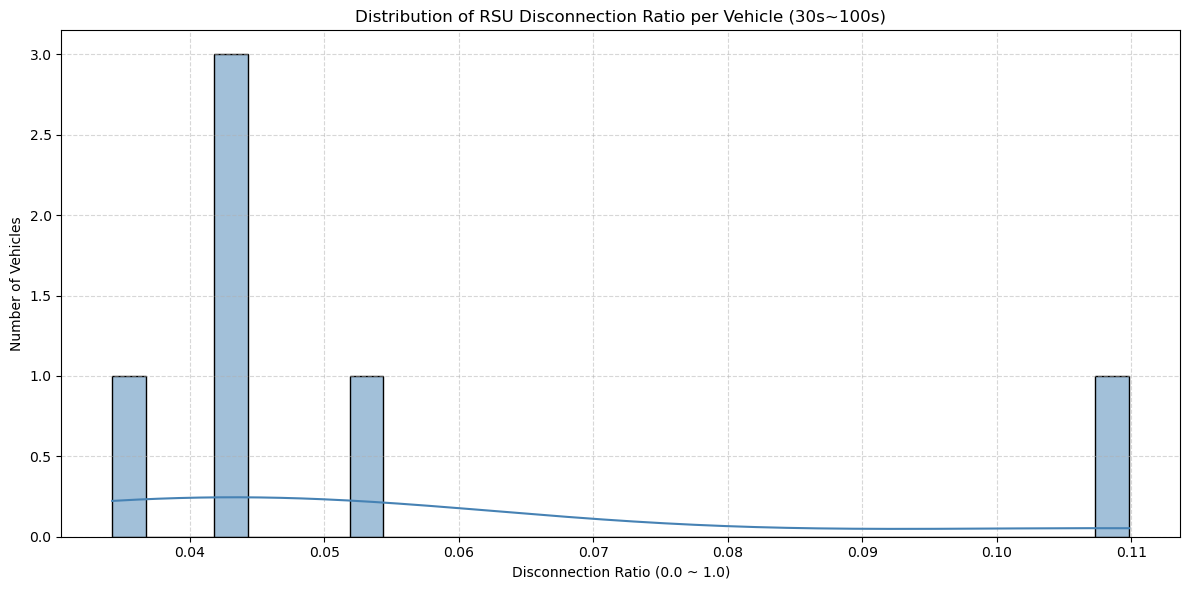

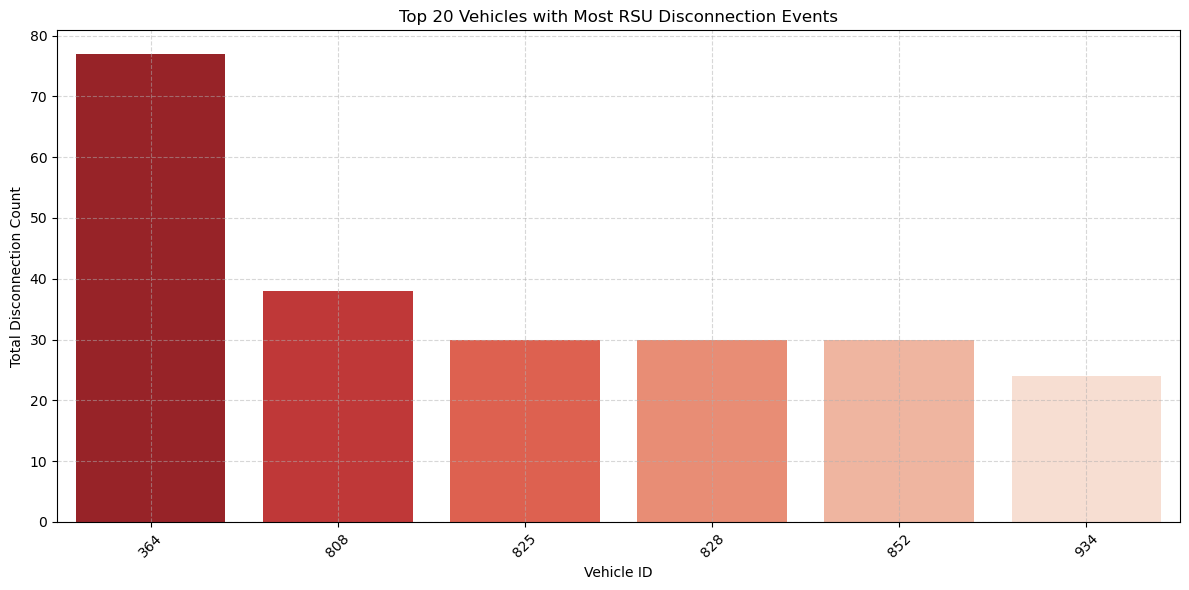

KeyError: 'vehicle_id'

In [7]:
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import math
from collections import defaultdict

def extract_data_for_all_vehicles(xml_path, time_range=(30.0, 100.0)):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    extracted_data = []
    for timestep in root.findall('timestep'):
        time = float(timestep.get('time'))
        if not (time_range[0] <= time <= time_range[1]):
            continue
        for vehicle in timestep.findall('vehicle'):
            vehicle_id = int(vehicle.get('id'))
            x = float(vehicle.get('x'))
            y = float(vehicle.get('y'))
            extracted_data.append((time, vehicle_id, x, y))
    return pd.DataFrame(extracted_data, columns=['time', 'vehicle_id', 'x', 'y'])

def analyze_rsu_connectivity_per_node(df: pd.DataFrame, rsu_pos=(800.0, 600.0), comm_range=110.0):
    failure_dict = defaultdict(list)
    grouped = df.groupby('time')

    for time, group in grouped:
        vehicles = group.set_index('vehicle_id')[['x', 'y']]
        coords = vehicles.to_numpy()
        vehicle_ids = vehicles.index.to_list()

        dists = np.sqrt(((coords[:, None, :] - coords[None, :, :]) ** 2).sum(axis=2))
        adj_matrix = (dists <= comm_range) & (dists > 0)

        rsu_idx = len(vehicle_ids)
        coords = np.vstack([coords, np.array([[rsu_pos[0], rsu_pos[1]]])])
        new_row = np.sqrt(((coords[:-1] - rsu_pos) ** 2).sum(axis=1)) <= comm_range
        adj_matrix = np.pad(adj_matrix, ((0, 1), (0, 1)), constant_values=False)
        adj_matrix[:-1, -1] = new_row
        adj_matrix[-1, :-1] = new_row

        G = nx.from_numpy_array(adj_matrix)

        for i, vehicle_id in enumerate(vehicle_ids):
            if not nx.has_path(G, rsu_idx, i):
                failure_dict[vehicle_id].append(time)

    return failure_dict

def summarize_disconnect_stats(failure_dict: dict, start_time=30.0, end_time=100.0):
    all_times = set(np.round(np.arange(start_time, end_time + 0.1, 0.1), 1))
    summary = []

    for vid, fail_times in failure_dict.items():
        fail_set = set(np.round(fail_times, 1))
        summary.append({
            'vehicle_id': vid,
            'total_disconnects': len(fail_set),
            'disconnect_ratio': len(fail_set) / len(all_times)
        })

    return pd.DataFrame(summary)

def visualize_disconnect_summary(summary_df: pd.DataFrame):
    plt.figure(figsize=(12, 6))
    sns.histplot(summary_df['disconnect_ratio'], bins=30, kde=True, color='steelblue')
    plt.title('Distribution of RSU Disconnection Ratio per Vehicle (30s~100s)')
    plt.xlabel('Disconnection Ratio (0.0 ~ 1.0)')
    plt.ylabel('Number of Vehicles')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 6))
    top_disconnects = summary_df.sort_values('total_disconnects', ascending=False).head(20)
    sns.barplot(x='vehicle_id', y='total_disconnects', data=top_disconnects, palette='Reds_r')
    plt.title('Top 20 Vehicles with Most RSU Disconnection Events')
    plt.xlabel('Vehicle ID')
    plt.ylabel('Total Disconnection Count')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

def visualize_consistently_present_disconnects(df: pd.DataFrame, failure_dict: dict, time_range=(30.0, 70.0), batch_size=10):
    start, end = time_range
    time_set = set(np.round(np.arange(start, end + 0.1, 0.1), 1))

    full_presence_vehicles = set()
    grouped = df.groupby('vehicle_id')
    required_len = len(time_set)

    for vid, group in grouped:
        times = set(np.round(group['time'].values, 1))
        if len(time_set - times) == 0:
            full_presence_vehicles.add(vid)

    filtered_summary = []
    for vid in sorted(full_presence_vehicles):
        times = failure_dict.get(vid, [])
        fail_times = set(np.round(times, 1)) & time_set
        if fail_times:
            filtered_summary.append({
                'vehicle_id': vid,
                'total_disconnects': len(fail_times),
                'disconnect_ratio': len(fail_times) / len(time_set)
            })

    df_filtered = pd.DataFrame(filtered_summary).sort_values('vehicle_id').reset_index(drop=True)
    total = len(df_filtered)

    if total == 0:
        print("30~70초 동안 내내 존재한 차량 중 RSU와 단절된 차량이 없습니다.")
        return

    num_batches = math.ceil(total / batch_size)

    for i in range(num_batches):
        batch = df_filtered.iloc[i*batch_size:(i+1)*batch_size]
        plt.figure(figsize=(10, 5))
        sns.barplot(x='vehicle_id', y='total_disconnects', data=batch, palette='crest')
        plt.title(f'RSU Disconnections (Only Fully Present Vehicles, 30s–70s)\nBatch {i+1}')
        plt.xlabel('Vehicle ID')
        plt.ylabel('Disconnection Count')
        plt.xticks(rotation=45)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    xml_file = "resource/map2.xml"
    df = extract_data_for_all_vehicles(xml_file, time_range=(30.0, 100.0))
    failure_dict = analyze_rsu_connectivity_per_node(df, rsu_pos=(800.0, 600.0), comm_range=166.0)
    summary_df = summarize_disconnect_stats(failure_dict, start_time=30.0, end_time=100.0)
    visualize_disconnect_summary(summary_df)
    visualize_consistently_present_disconnects(df, failure_dict, time_range=(30.0, 100.0), batch_size=30)

0

c:\Conda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


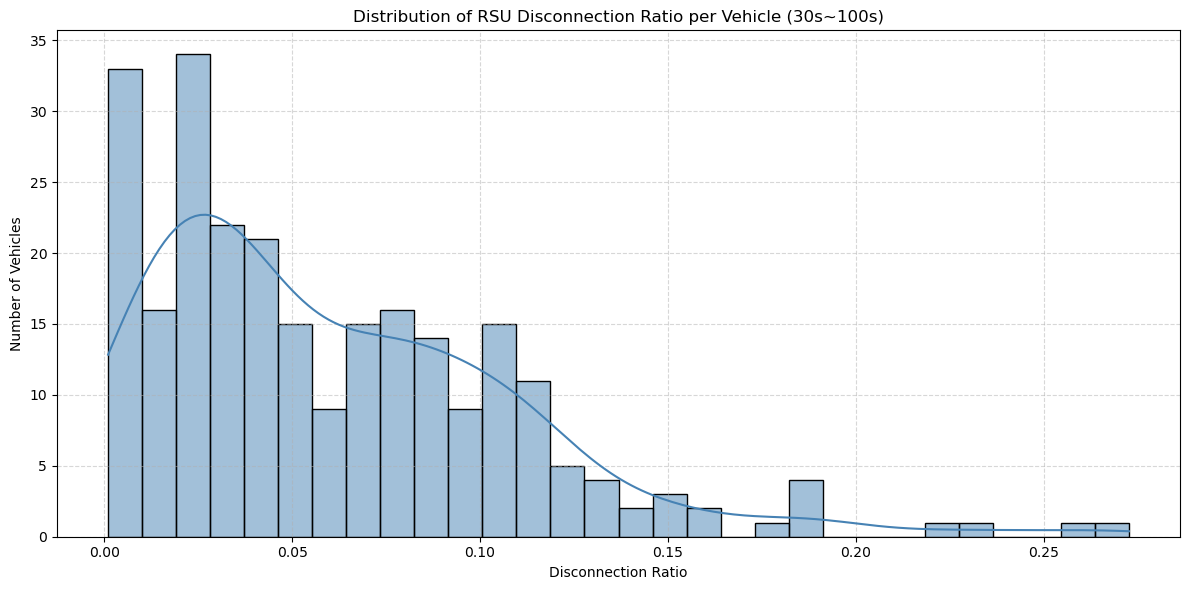

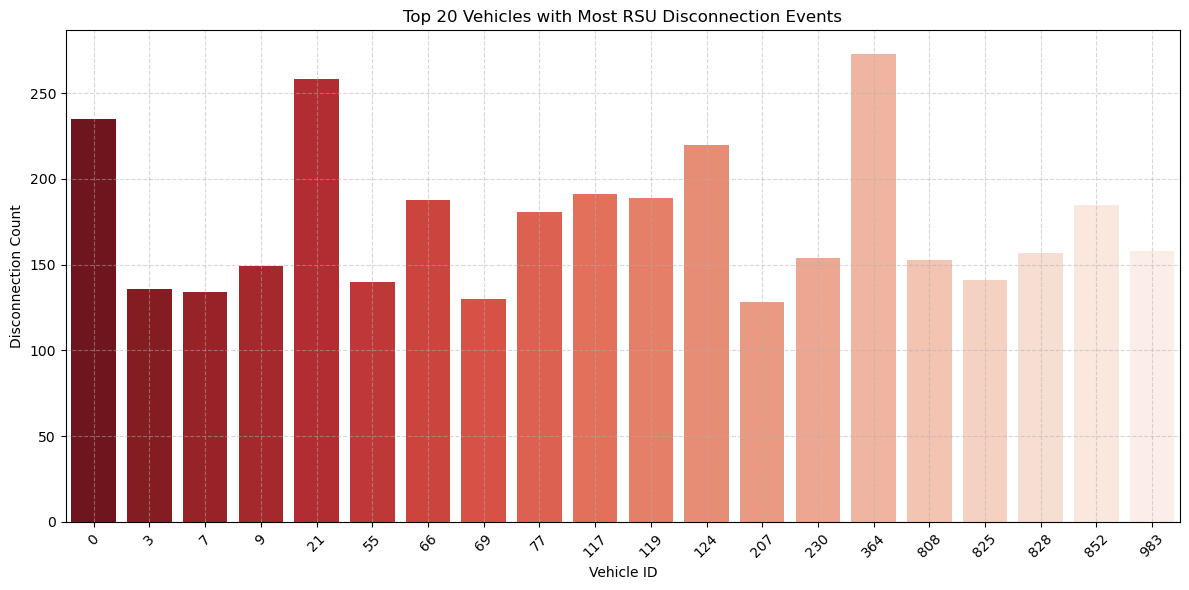

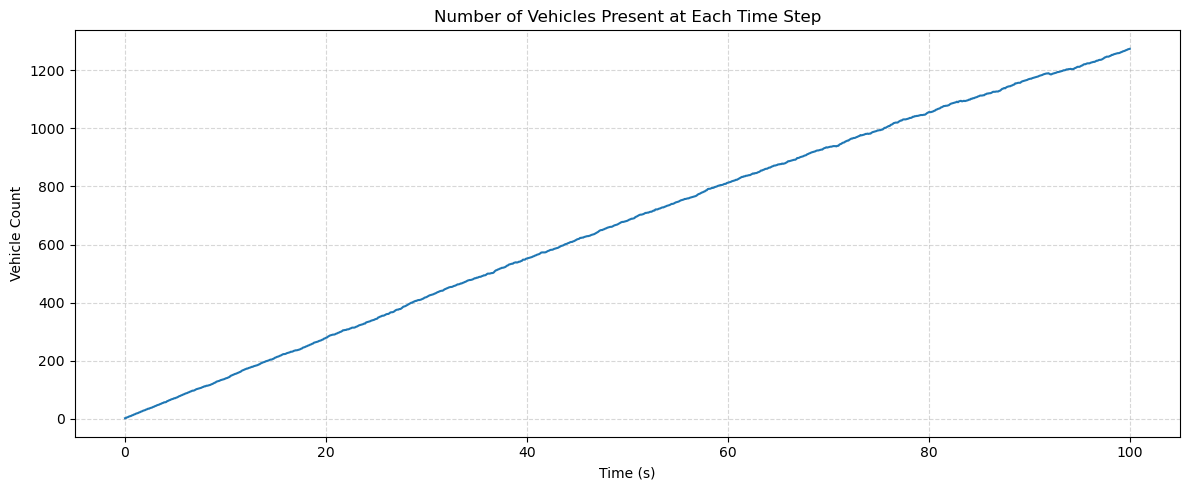

In [1]:
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from collections import defaultdict
import math

def extract_dynamic_vehicle_pool(xml_path, time_range=(30.0, 100.0), vehicle_limit=300):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    time_start, time_end = time_range
    vehicle_pool = set()
    extracted_data = []

    for timestep in root.findall('timestep'):
        time = float(timestep.get('time'))
        if not (time_start <= time <= time_end):
            continue

        vehicles_in_step = []
        new_vehicles = []

        for vehicle in timestep.findall('vehicle'):
            vid = int(vehicle.get('id'))
            x = float(vehicle.get('x'))
            y = float(vehicle.get('y'))

            if vid in vehicle_pool:
                vehicles_in_step.append((vid, x, y))
            else:
                new_vehicles.append((vid, x, y))

        current_count = len(vehicles_in_step)
        if current_count < vehicle_limit:
            to_add = min(vehicle_limit - current_count, len(new_vehicles))
            vehicles_in_step.extend(new_vehicles[:to_add])
            for item in new_vehicles[:to_add]:
                vehicle_pool.add(item[0])

        for vid, x, y in vehicles_in_step:
            extracted_data.append((time, vid, x, y))

    df = pd.DataFrame(extracted_data, columns=['time', 'vehicle_id', 'x', 'y'])
    return df

def analyze_rsu_connectivity_per_node(df, rsu_pos=(800.0, 600.0), comm_range=110.0):
    failure_dict = defaultdict(list)
    grouped = df.groupby('time')

    for time, group in grouped:
        vehicles = group.set_index('vehicle_id')[['x', 'y']]
        coords = vehicles.to_numpy()
        vehicle_ids = vehicles.index.to_list()

        dists = np.sqrt(((coords[:, None, :] - coords[None, :, :]) ** 2).sum(axis=2))
        adj_matrix = (dists <= comm_range) & (dists > 0)

        rsu_idx = len(vehicle_ids)
        coords = np.vstack([coords, np.array([[rsu_pos[0], rsu_pos[1]]])])
        new_row = np.sqrt(((coords[:-1] - rsu_pos) ** 2).sum(axis=1)) <= comm_range
        adj_matrix = np.pad(adj_matrix, ((0, 1), (0, 1)), constant_values=False)
        adj_matrix[:-1, -1] = new_row
        adj_matrix[-1, :-1] = new_row

        G = nx.from_numpy_array(adj_matrix)

        for i, vehicle_id in enumerate(vehicle_ids):
            if not nx.has_path(G, rsu_idx, i):
                failure_dict[vehicle_id].append(time)

    return failure_dict

def summarize_disconnect_stats(failure_dict, start_time=30.0, end_time=100.0):
    all_times = set(np.round(np.arange(start_time, end_time + 0.1, 0.1), 1))
    summary = []

    for vid, fail_times in failure_dict.items():
        fail_set = set(np.round(fail_times, 1))
        summary.append({
            'vehicle_id': vid,
            'total_disconnects': len(fail_set),
            'disconnect_ratio': len(fail_set) / len(all_times)
        })

    return pd.DataFrame(summary)

def visualize_disconnect_summary(summary_df):
    plt.figure(figsize=(12, 6))
    sns.histplot(summary_df['disconnect_ratio'], bins=30, kde=True, color='steelblue')
    plt.title('Distribution of RSU Disconnection Ratio per Vehicle (30s~100s)')
    plt.xlabel('Disconnection Ratio')
    plt.ylabel('Number of Vehicles')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 6))
    top = summary_df.sort_values('total_disconnects', ascending=False).head(20)
    sns.barplot(x='vehicle_id', y='total_disconnects', data=top, palette='Reds_r')
    plt.title('Top 20 Vehicles with Most RSU Disconnection Events')
    plt.xlabel('Vehicle ID')
    plt.ylabel('Disconnection Count')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

def plot_vehicle_count(df):
    count_df = df.groupby('time')['vehicle_id'].nunique().reset_index()
    plt.figure(figsize=(12, 5))
    plt.plot(count_df['time'], count_df['vehicle_id'])
    plt.title('Number of Vehicles Present at Each Time Step')
    plt.xlabel('Time (s)')
    plt.ylabel('Vehicle Count')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    xml_file = "resource/map5.xml"
    time_range = (0.0, 100.0)
    vehicle_limit = 400000

    df = extract_dynamic_vehicle_pool(xml_file, time_range=time_range, vehicle_limit=vehicle_limit)
    failure_dict = analyze_rsu_connectivity_per_node(df, rsu_pos=(800.0, 600.0), comm_range=110.0)
    summary_df = summarize_disconnect_stats(failure_dict, start_time=time_range[0], end_time=time_range[1])
    visualize_disconnect_summary(summary_df)
    plot_vehicle_count(df)


[INFO] Included vehicle IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217,

c:\Conda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


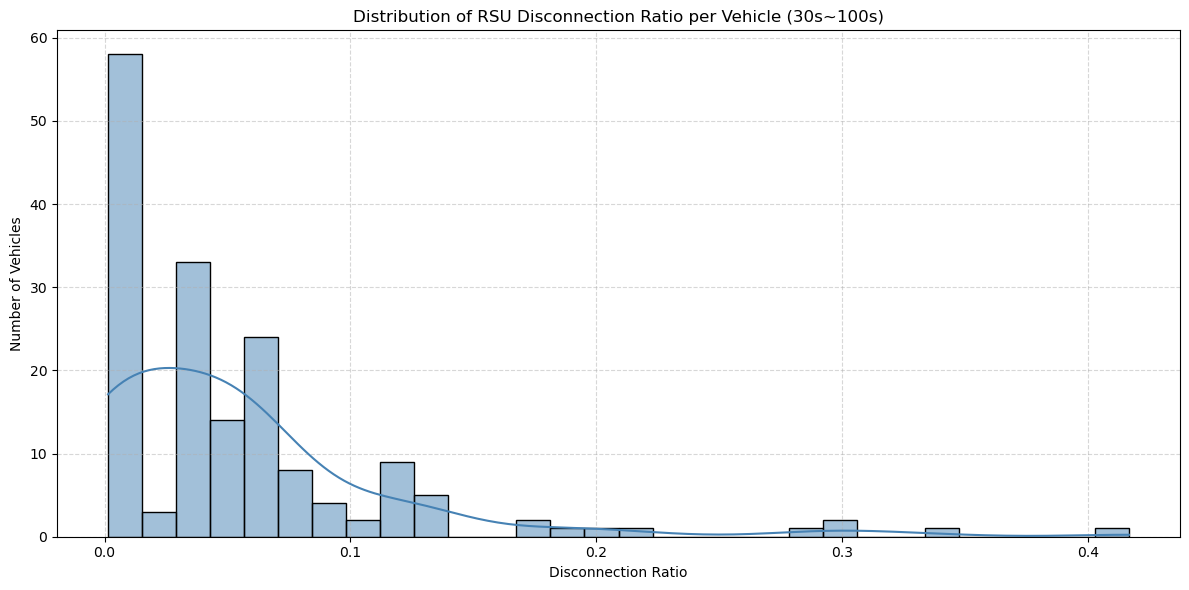

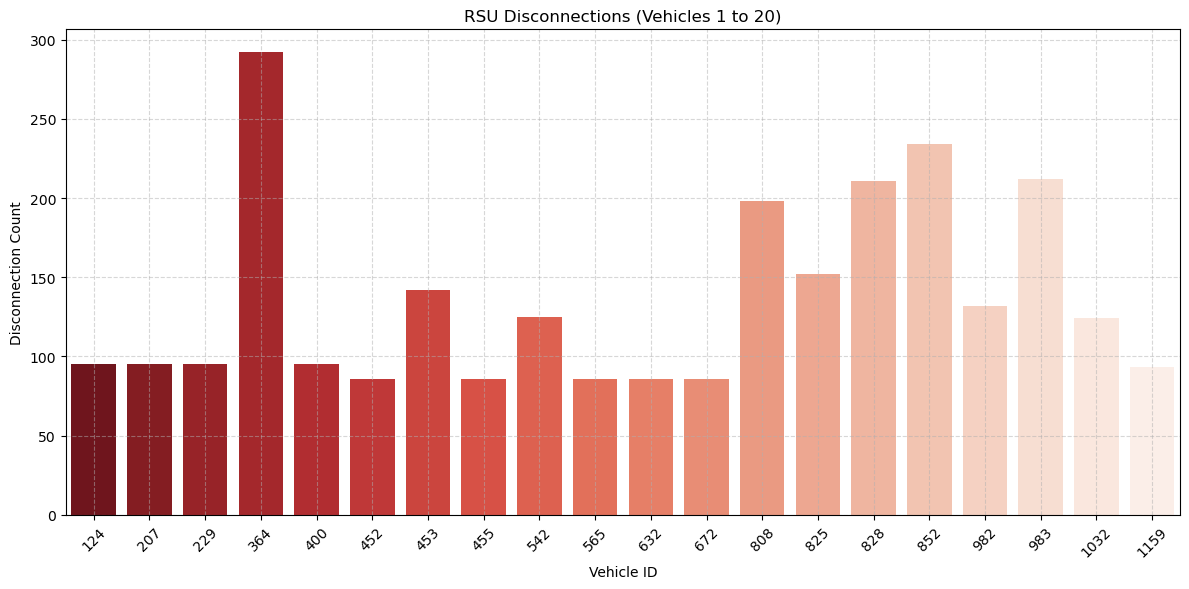

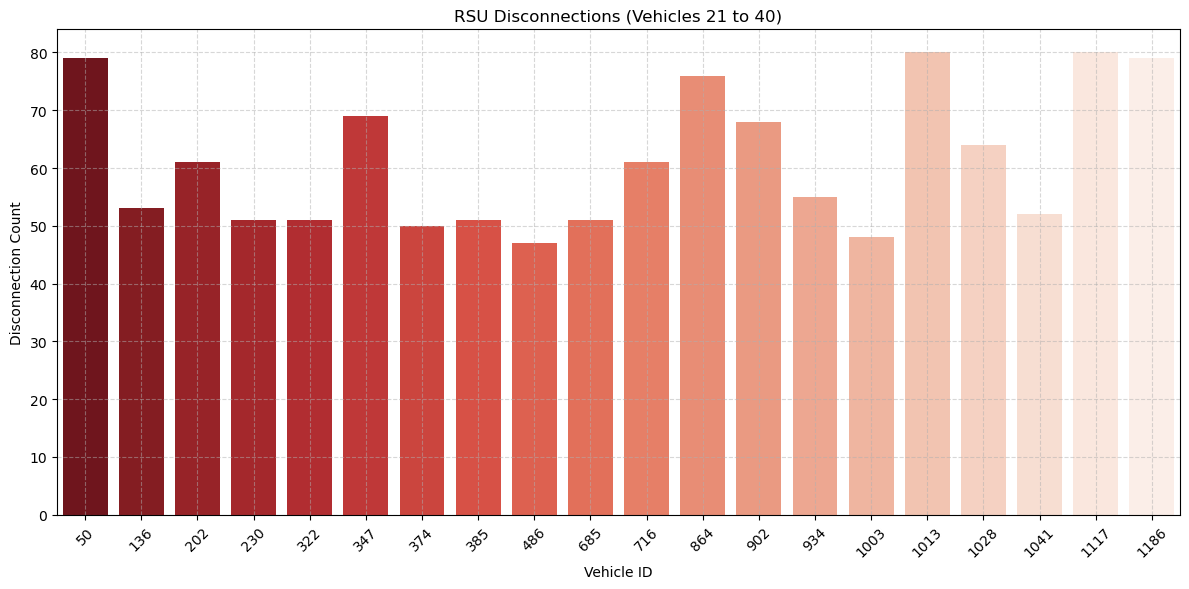

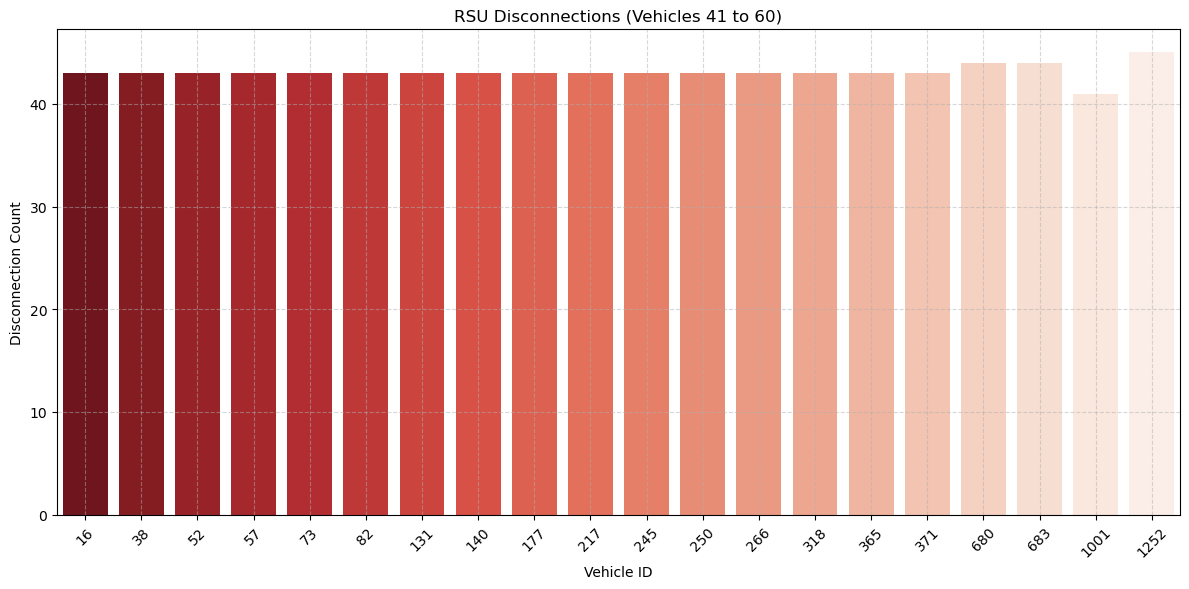

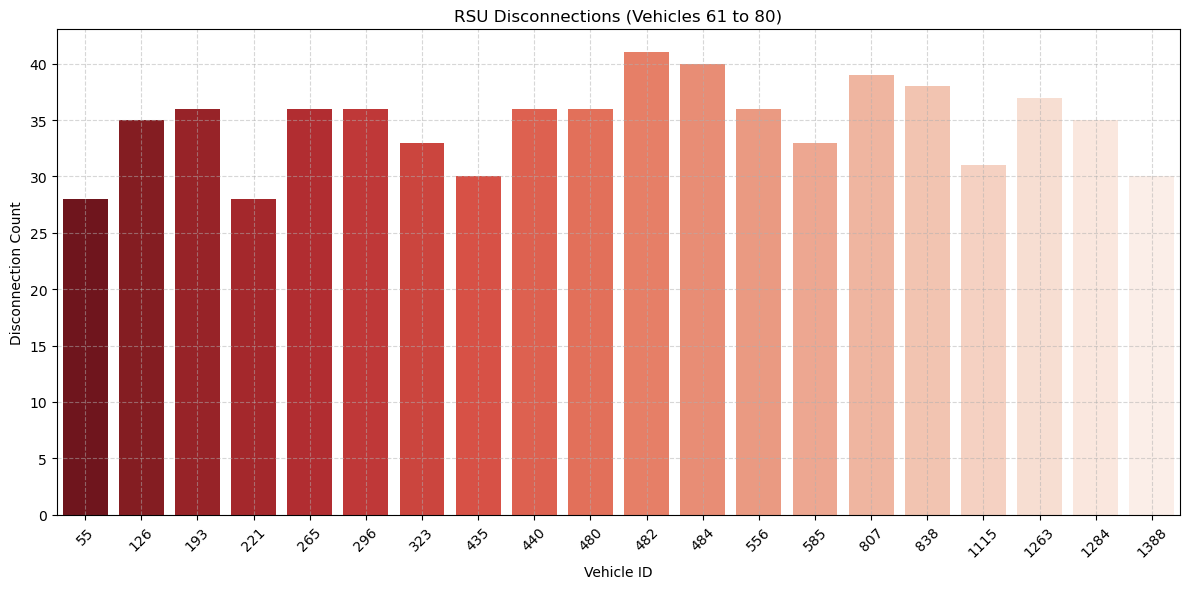

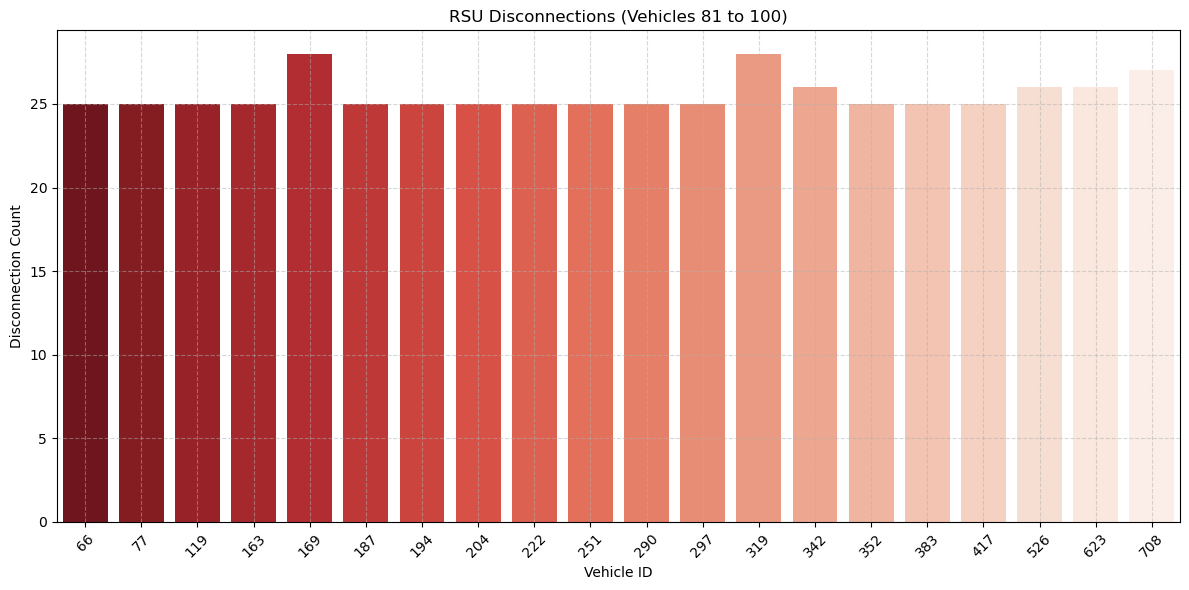

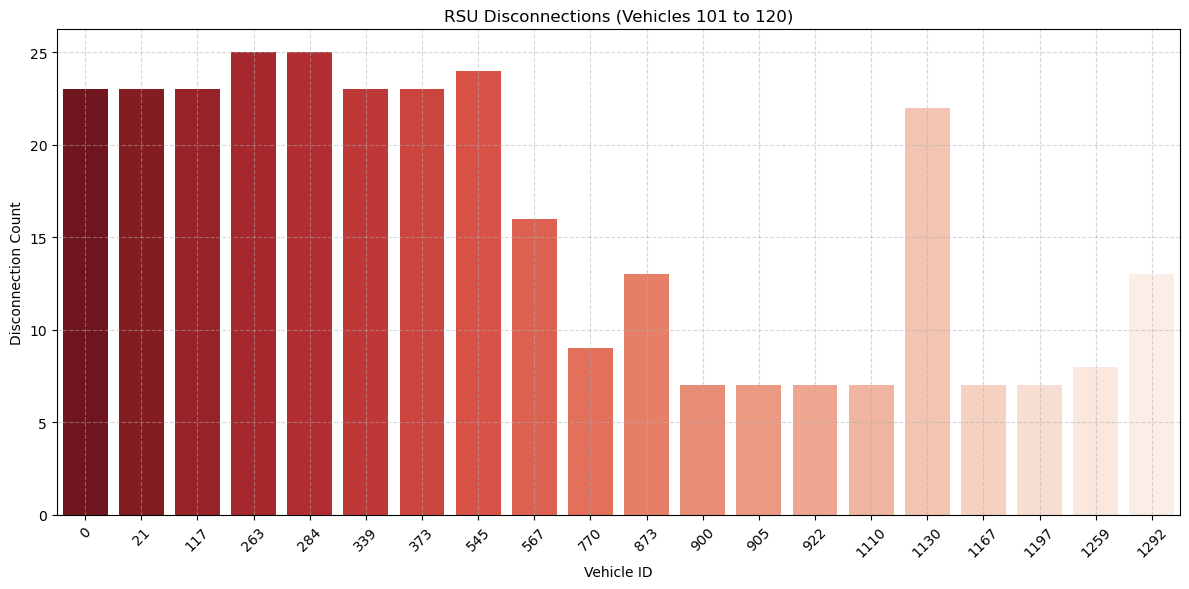

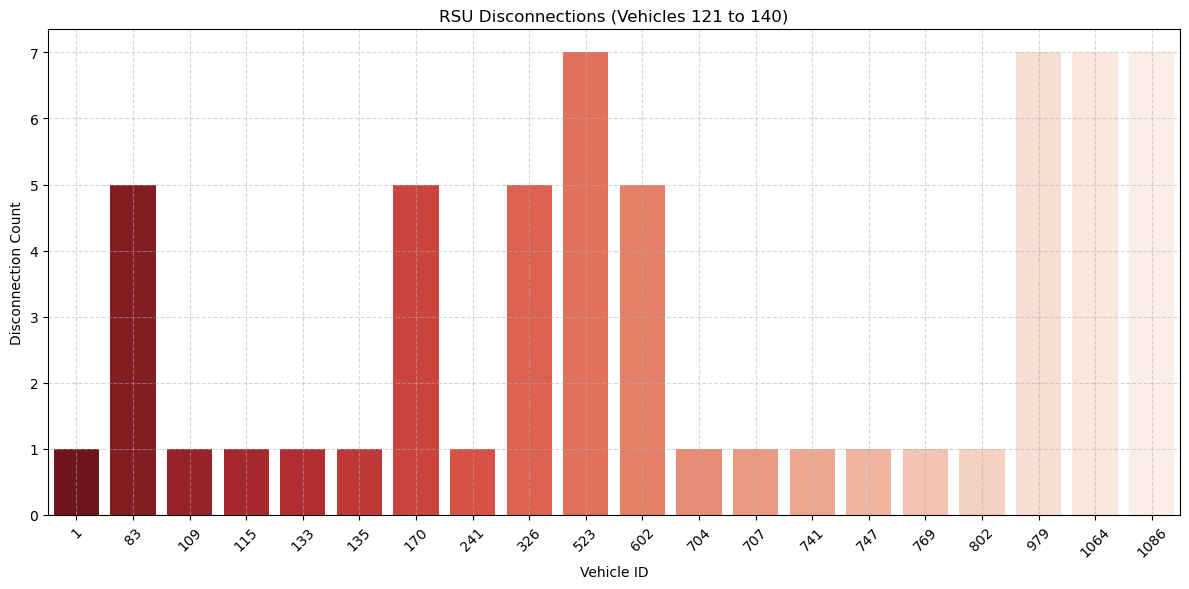

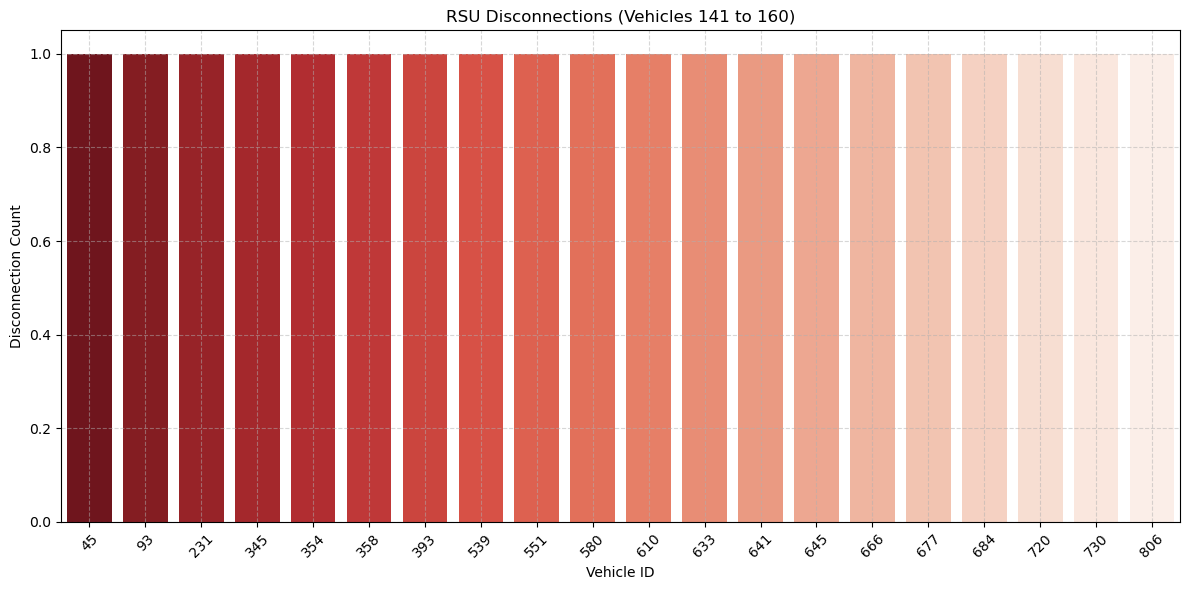

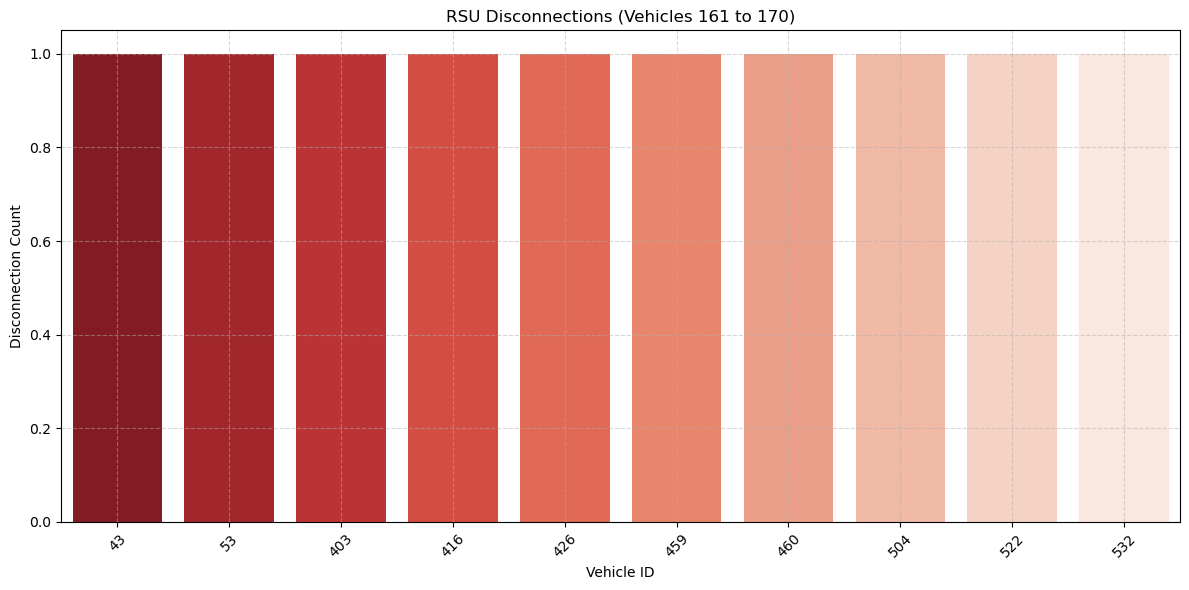

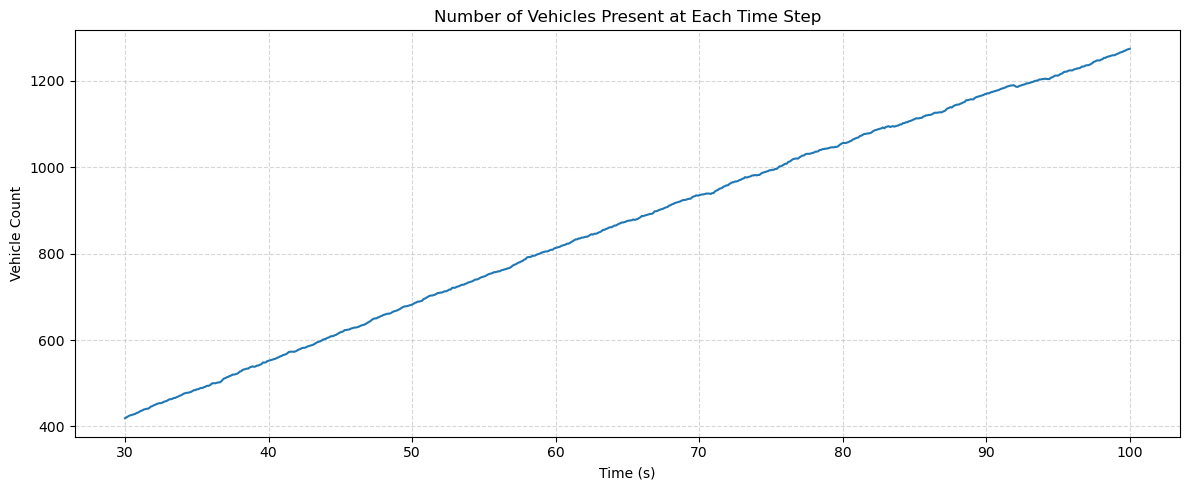

In [5]:
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from collections import defaultdict
import math

def extract_dynamic_vehicle_pool(xml_path, time_range=(30.0, 100.0), vehicle_limit=100000):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    time_start, time_end = time_range
    vehicle_pool = set()
    extracted_data = []

    for timestep in root.findall('timestep'):
        time = float(timestep.get('time'))
        if not (time_start <= time <= time_end):
            continue

        vehicles_in_step = []
        new_vehicles = []

        for vehicle in timestep.findall('vehicle'):
            vid_raw = vehicle.get('id')
            try:
                vid = int(vid_raw)
            except:
                continue  # skip non-numeric id like 'veh12'

            x = float(vehicle.get('x'))
            y = float(vehicle.get('y'))

            if vid in vehicle_pool:
                vehicles_in_step.append((vid, x, y))
            else:
                new_vehicles.append((vid, x, y))

        current_count = len(vehicles_in_step)
        if current_count < vehicle_limit:
            to_add = min(vehicle_limit - current_count, len(new_vehicles))
            vehicles_in_step.extend(new_vehicles[:to_add])
            for item in new_vehicles[:to_add]:
                vehicle_pool.add(item[0])

        for vid, x, y in vehicles_in_step:
            extracted_data.append((time, vid, x, y))

    df = pd.DataFrame(extracted_data, columns=['time', 'vehicle_id', 'x', 'y'])

    print(f"[INFO] Included vehicle IDs: {sorted(df['vehicle_id'].unique())}")
    if 12 not in df['vehicle_id'].values:
        print("[WARNING] Vehicle 12 not found in dataset.")

    return df

def analyze_rsu_connectivity_per_node(df, rsu_pos=(800.0, 600.0), comm_range=110.0):
    failure_dict = defaultdict(list)
    grouped = df.groupby('time')

    for time, group in grouped:
        vehicles = group.set_index('vehicle_id')[['x', 'y']]
        coords = vehicles.to_numpy()
        vehicle_ids = vehicles.index.to_list()

        dists = np.sqrt(((coords[:, None, :] - coords[None, :, :]) ** 2).sum(axis=2))
        adj_matrix = (dists <= comm_range) & (dists > 0)

        rsu_idx = len(vehicle_ids)
        coords = np.vstack([coords, np.array([[rsu_pos[0], rsu_pos[1]]])])
        new_row = np.sqrt(((coords[:-1] - rsu_pos) ** 2).sum(axis=1)) <= comm_range
        adj_matrix = np.pad(adj_matrix, ((0, 1), (0, 1)), constant_values=False)
        adj_matrix[:-1, -1] = new_row
        adj_matrix[-1, :-1] = new_row

        G = nx.from_numpy_array(adj_matrix)

        for i, vehicle_id in enumerate(vehicle_ids):
            if not nx.has_path(G, rsu_idx, i):
                failure_dict[vehicle_id].append(time)

    return failure_dict

def summarize_disconnect_stats(failure_dict, start_time=30.0, end_time=100.0):
    all_times = set(np.round(np.arange(start_time, end_time + 0.1, 0.1), 1))
    summary = []

    for vid, fail_times in failure_dict.items():
        fail_set = set(np.round(fail_times, 1))
        summary.append({
            'vehicle_id': vid,
            'total_disconnects': len(fail_set),
            'disconnect_ratio': len(fail_set) / len(all_times)
        })

    return pd.DataFrame(summary)

def visualize_disconnect_summary(summary_df):
    plt.figure(figsize=(12, 6))
    sns.histplot(summary_df['disconnect_ratio'], bins=30, kde=True, color='steelblue')
    plt.title('Distribution of RSU Disconnection Ratio per Vehicle (30s~100s)')
    plt.xlabel('Disconnection Ratio')
    plt.ylabel('Number of Vehicles')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    sorted_df = summary_df.sort_values('total_disconnects', ascending=False)
    vehicles_per_plot = 20
    total = len(sorted_df)
    num_plots = (total + vehicles_per_plot - 1) // vehicles_per_plot

    for i in range(num_plots):
        start = i * vehicles_per_plot
        end = min(start + vehicles_per_plot, total)
        subset = sorted_df.iloc[start:end]

        plt.figure(figsize=(12, 6))
        sns.barplot(x='vehicle_id', y='total_disconnects', data=subset, palette='Reds_r')
        plt.title(f'RSU Disconnections (Vehicles {start + 1} to {end})')
        plt.xlabel('Vehicle ID')
        plt.ylabel('Disconnection Count')
        plt.xticks(rotation=45)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()


def plot_vehicle_count(df):
    count_df = df.groupby('time')['vehicle_id'].nunique().reset_index()
    plt.figure(figsize=(12, 5))
    plt.plot(count_df['time'], count_df['vehicle_id'])
    plt.title('Number of Vehicles Present at Each Time Step')
    plt.xlabel('Time (s)')
    plt.ylabel('Vehicle Count')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    xml_file = "resource/map5.xml"
    time_range = (30.0, 100.0)
    vehicle_limit = 100000

    df = extract_dynamic_vehicle_pool(xml_file, time_range=time_range, vehicle_limit=vehicle_limit)
    failure_dict = analyze_rsu_connectivity_per_node(df, rsu_pos=(800.0, 600.0), comm_range=100.0)
    summary_df = summarize_disconnect_stats(failure_dict, start_time=time_range[0], end_time=time_range[1])
    visualize_disconnect_summary(summary_df)
    plot_vehicle_count(df)
